In [1]:
import sys
import os

# Add the pyquantifier directory to the Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from collections import Counter
import numpy as np
from scipy.stats import beta

from pyquantifier.distributions import MixtureCUD, ExtrinsicJointDistribution
from pyquantifier.calibration_curve import PlattScaling
from pyquantifier.data import Item, Dataset

# Purpose of this Notebook

I am implementing some alternative calibration curve methods and using this notebook to test them out.

1. Generate a dataset with a known calibration curve (parameterized by logit regression parameters)
2. Subsample to create a calibration sample
3. Fit a calibration curve to the calibration sample using different methods
- Platt scaling
- BinnedCalibrationCurve
- PiecewiseLinearCalibrationCurve
- WeightedPiecewiseLinearCalibrationCurve
4. Evaluate the calibration curves on the full dataset: which come closest to recovering the correct calibration curve and prevalence estimate

## 1 Extrinsic data generator

### 1.1 Generate dataset

In [3]:
def generate_extrinsic_dataset(classifer_score_density_rv, w, b, num_base_size):
    # 1. Generate a dataset with `num_sample` items,
    # which pos scores follow the `classifer_score_density` distribution
    all_labels = ["pos", "neg"]
    simulated_pos_scores = classifer_score_density_rv.generate_data(num_base_size)

    calibration_curve = PlattScaling()
    calibration_curve.set_params(w, b)

    items = []
    gt_label_dict = {}
    for idx, pos_score in enumerate(simulated_pos_scores):
        item = Item(
            uid=idx + 1, all_labels=all_labels, all_probs=[pos_score, 1 - pos_score]
        )
        items.append(item)

        calibrated_pos_score = calibration_curve.get_calibrated_prob(pos_score)[0]
        gt_label_dict[item.uid] = np.random.choice(
            all_labels, p=[calibrated_pos_score, 1 - calibrated_pos_score]
        )

    dataset = Dataset(items=items)
    return dataset, gt_label_dict

In [4]:
classifer_score_density_rv = MixtureCUD(
    components=[beta(10, 2), beta(2, 5)], weights=[2, 8]
)
(w, b) = (21.92, -14.61)
num_base_size = 1000000
num_base_size = 10000
num_bin = 10

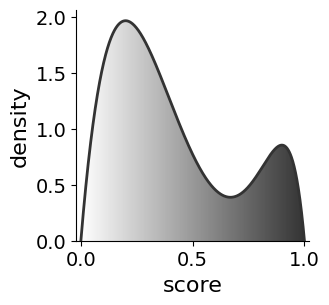

In [5]:
classifer_score_density_rv.plot()

In [6]:
extrinsic_base_dataset, extrinsic_gt_label_dict = generate_extrinsic_dataset(
    classifer_score_density_rv, w, b, num_base_size
)

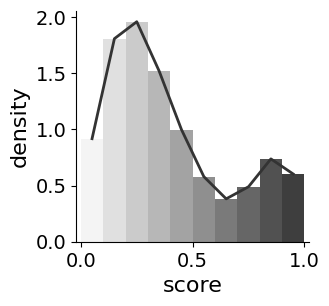

In [7]:
extrinsic_base_dataset.classifier_score_distribution = (
    extrinsic_base_dataset.infer_classifier_score_distribution(num_bin=num_bin)
)
extrinsic_base_dataset.classifier_score_distribution.plot()

In [8]:
# ground truth prevalence
Counter(extrinsic_gt_label_dict.values())["pos"] / num_base_size

0.1945

### 1.2 Subsample calibration sample

In [9]:
num_sample = 1500

array([<AxesSubplot:title={'center':'Class Conditional Densities'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Label Density'}>,
       <AxesSubplot:title={'center':'Joint Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Classifier Score Density'}, xlabel='score', ylabel='density'>,
       <AxesSubplot:title={'center':'Calibration Curve'}, xlabel='Predicted Probability', ylabel='Fraction of Positives'>],
      dtype=object)

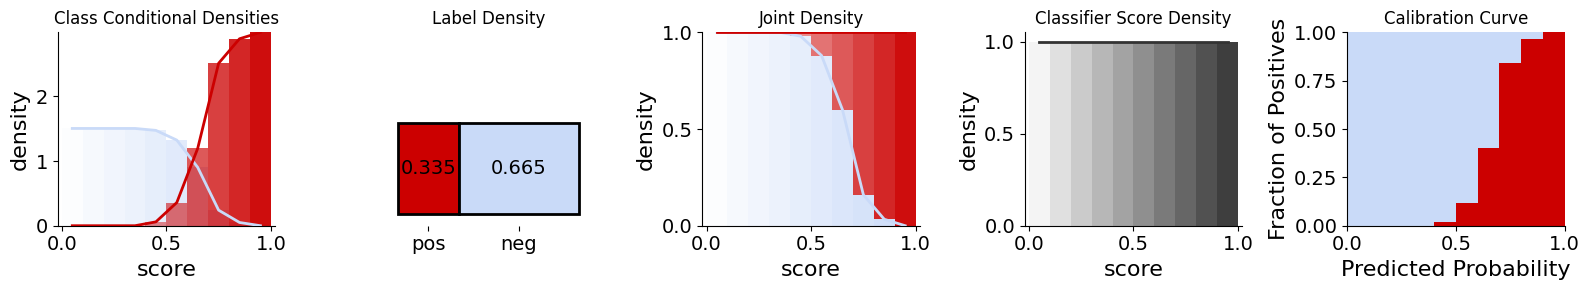

In [10]:
# 2. Select a subset of the dataset and annotate the labels
extrinsic_selected_dataset, extrinsic_selection_weights = (
    extrinsic_base_dataset.select_sample_for_annotation(
        n=num_sample, strategy="uniform", bins=num_bin
    )
)
annotated_labels = [
    extrinsic_gt_label_dict[uid]
    for uid in extrinsic_selected_dataset.df["uid"].values.astype(int)
]
extrinsic_selected_dataset.annotate_sample(annotated_labels)

extrinsic_selected_dataset.profile_dataset()

### 1.3 Estimate calibration curve from calibration sample

In [11]:
binning_calibration_curve = extrinsic_selected_dataset.calibration_curve

In [12]:
extrinsic_selected_dataset.update_calibration_curve(method="platt scaling")
ps_calibration_curve = extrinsic_selected_dataset.calibration_curve

estimated_w, estimated_b = ps_calibration_curve.get_params()
estimated_w = estimated_w.item()
estimated_b = estimated_b.item()

print(f"True w: {w}, True b: {b}")
print(f"Estimated w: {estimated_w}, Estimated b: {estimated_b}")

True w: 21.92, True b: -14.61
Estimated w: 11.499204488758544, Estimated b: -7.653793887539771


In [13]:
extrinsic_selected_dataset.update_calibration_curve(method="piecewise linear")
piecewise_linear_calibration_curve = extrinsic_selected_dataset.calibration_curve

In [14]:
extrinsic_selected_dataset.update_calibration_curve(method="adjusted piecewise linear")
adjusted_piecewise_linear_calibration_curve = (
    extrinsic_selected_dataset.calibration_curve
)

In [ ]:
extrinsic_selected_dataset.update_calibration_curve(method="isotonic regression")
isotonic_calibration_curve = extrinsic_selected_dataset.calibration_curve

### 1.4 Show plots, including Prevalence estimation

0.19703800000000002
[0.         0.         0.         0.         0.02       0.12
 0.4        0.84       0.96666667 1.         1.        ]
0.19693623968266555
[0.         0.         0.         0.         0.01       0.07
 0.26       0.62       0.90333333 0.98333333 1.        ]
0.19766965954739962
[0.         0.         0.         0.         0.01062905 0.07577594
 0.26966576 0.61391219 0.90099169 0.98526262 1.        ]
0.1969652613161135
[0.         0.         0.         0.         0.         0.02803738
 0.20588235 0.6875     0.93220339 1.         1.        ]


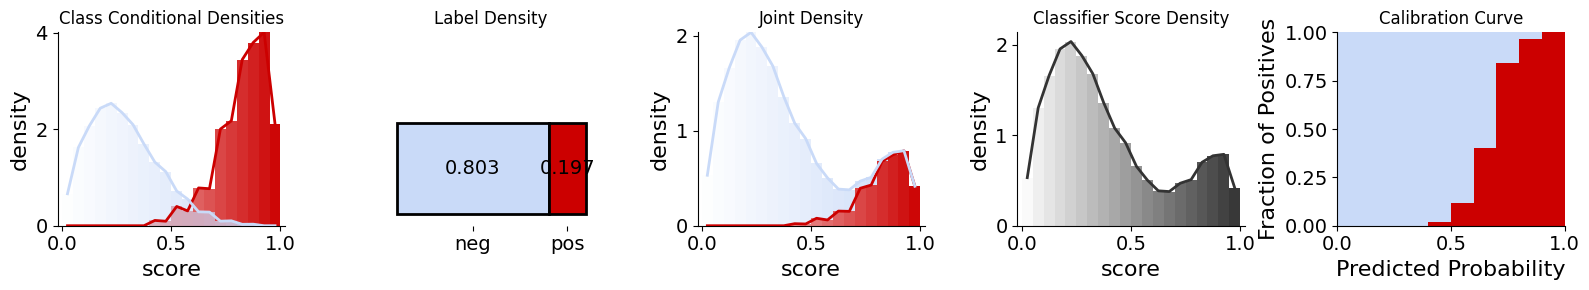

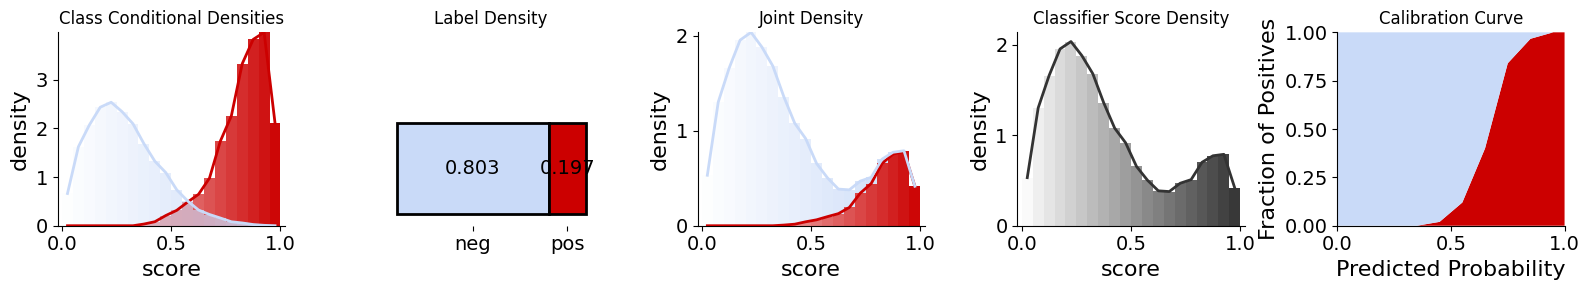

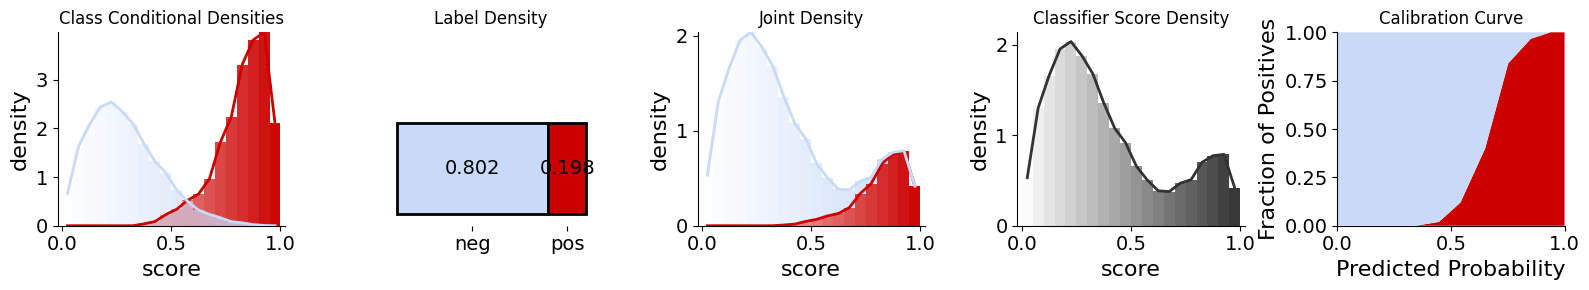

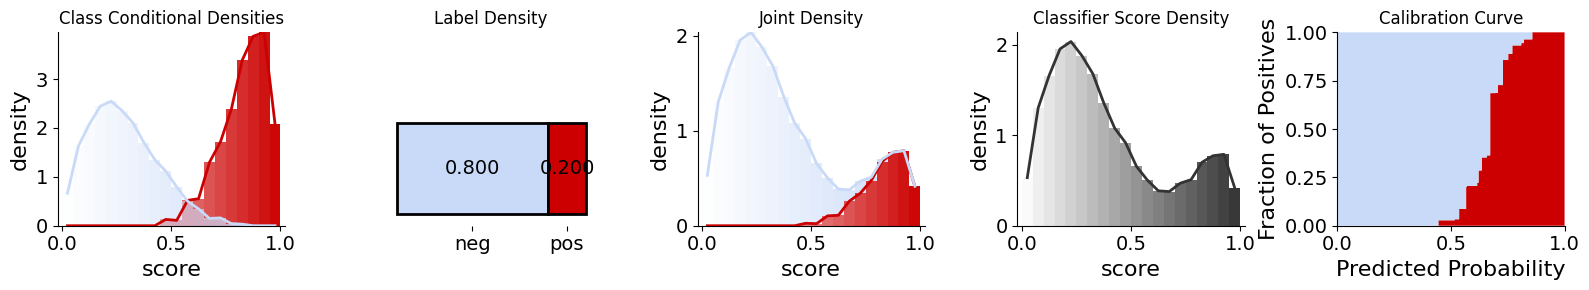

In [ ]:
for cc in [
    binning_calibration_curve,
    piecewise_linear_calibration_curve,
    adjusted_piecewise_linear_calibration_curve,
    isotonic_calibration_curve,
]:
    jd = ExtrinsicJointDistribution(labels, classifier_density, cc)
    print(extrinsic_base_dataset.extrinsic_estimate(calibration_curve=cc))
    print(cc.get_calibrated_prob(np.linspace(0, 1, 11)))
    jd.plot_five_distributions()
    None